In [1]:
!pip install dgl
!pip install networkx

     |████████████████████████████████| 3.0MB 2.8MB/s 


In [0]:
import torch

### Let's start out of the box and draw a graph

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


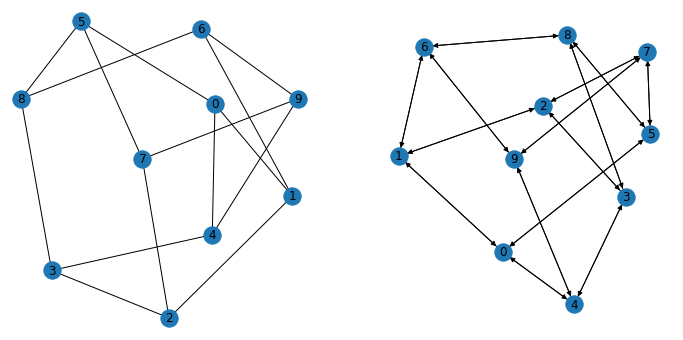

In [2]:
import networkx as nx
import dgl

g_nx = nx.petersen_graph()
g_dgl = dgl.DGLGraph(g_nx)

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12,6)

plt.subplot(121)
nx.draw(g_nx, with_labels=True)
plt.subplot(122)
nx.draw(g_dgl.to_networkx(), with_labels=True)

plt.show()


### Building a graph from scratch

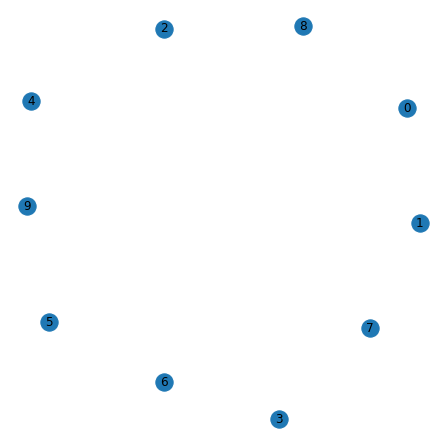

In [3]:
import torch as th

plt.rcParams["figure.figsize"] = (6,6)
g = dgl.DGLGraph()
g.add_nodes(10)
# # a couple edges one-by-one
# for i in range(1, 4):
#     g.add_edge(i, 0)
# # a few more with a paired list
# src = list(range(5, 8)); dst = [0]*3
# g.add_edges(src, dst)
# # finish with a pair of tensors
# src = th.tensor([8, 9]); dst = th.tensor([0, 0])
# g.add_edges(src, dst)

# # edge broadcasting will do star graph in one go!
# g.clear(); g.add_nodes(10)
# src = th.tensor(list(range(1, 10)));
# g.add_edges(src, 0)

nx.draw(g.to_networkx(), with_labels=True)
plt.show()

### Define the edges with a start-node and an end-node

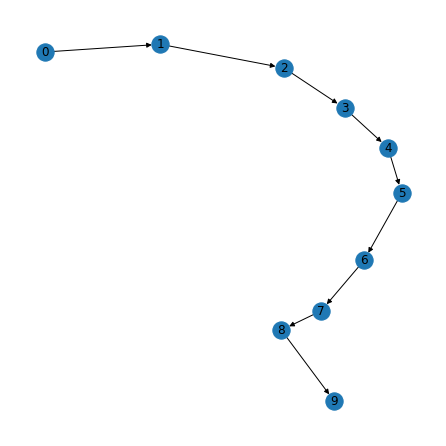

In [4]:
for i in range(0, 9):
    g.add_edge(i, i+1)
nx.draw(g.to_networkx(), with_labels=True)
plt.show()

### Nodes as a vector in DGL and NetworkX

In [5]:
g.nodes()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [6]:
g.to_networkx().nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9))

### Features to nodes and edges

In [0]:
# --- creating a graph with 10 nodes -- #
g = dgl.DGLGraph()
g.add_nodes(10)

In [8]:
g.nodes[1]

NodeSpace(data={})

In [9]:
g.edges()

(tensor([], dtype=torch.int64), tensor([], dtype=torch.int64))

### Assigning data on the nodes 

In [0]:
x = th.randn(10, 3)
g.ndata['x'] = x # -- assigning a name to the feature : 'x'

In [11]:
g.ndata

{'x': tensor([[ 1.2588, -1.2061, -0.1707],
        [ 0.1905,  0.4798, -0.7069],
        [-0.8687, -1.6214,  0.9684],
        [ 1.1367, -0.9622, -0.0217],
        [ 0.4419,  1.2285,  1.3137],
        [ 0.1912, -1.5650, -1.0555],
        [-0.4762, -0.8635,  1.5131],
        [ 0.5984, -0.7854, -0.2562],
        [-0.4380,  1.5678,  0.3665],
        [ 0.0184, -0.4401,  1.0582]])}

### Data on a particular node

In [12]:
g.nodes[3].data['x'], g.ndata['x'][3]

(tensor([[ 1.1367, -0.9622, -0.0217]]), tensor([ 1.1367, -0.9622, -0.0217]))

###  What if I want to assign features to any individual node ?

In [0]:
# access node set with integer, list, or integer tensor
g.nodes[0].data['x'] = 2 * th.ones(1, 3)
g.nodes[[1, 2]].data['x'] = th.zeros(2, 3)


### Another way to add edges at one go

In [0]:
# edge broadcasting will do star graph in one go!
g.clear(); g.add_nodes(10)
src = th.tensor(list(range(1, 10)));
g.add_edges(src, 0)

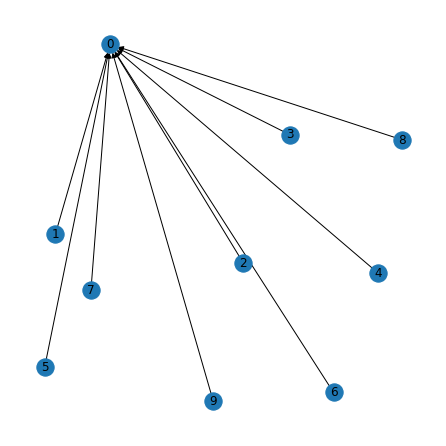

In [15]:
nx.draw(g.to_networkx(), with_labels=True)
plt.show()

### Adding feature to edges in two different ways 

In [0]:
g.edata['w'] = th.randn(9, 2)

# access edge set with IDs in integer, list, or integer tensor
g.edges[1].data['w'] = th.randn(1, 2)
g.edges[[0, 1, 2]].data['w'] = th.zeros(3, 2)
g.edges[th.tensor([0, 1, 2])].data['w'] = th.zeros(3, 2)

# one can also access the edges by giving endpoints
g.edges[1, 0].data['w'] = th.ones(1, 2)                 # edge 1 -> 0
g.edges[[1, 2, 3], [0, 0, 0]].data['w'] = th.ones(3, 2) # edges [1, 2, 3] -> 0

In [0]:
x = th.randn(10, 3)
g.ndata['x'] = x

### Accessing the edges 

In [18]:
g.edges()

(tensor([1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0]))

### How to acceess the data on the edges ?

In [19]:
g.edges[6, 0] 

EdgeSpace(data={'w': tensor([[ 0.1590, -1.4162]])})

In [20]:
g.edges[6, 0].data

{'w': tensor([[ 0.1590, -1.4162]])}

In [0]:
edg = g.edges[6, 0] 

In [22]:
edg.data

{'w': tensor([[ 0.1590, -1.4162]])}

In [23]:
g.nodes[1]

NodeSpace(data={'x': tensor([[ 0.0953, -0.5192, -0.1165]])})

## Message passing
### a node data is updated by aggregating information from neighbouring nodes

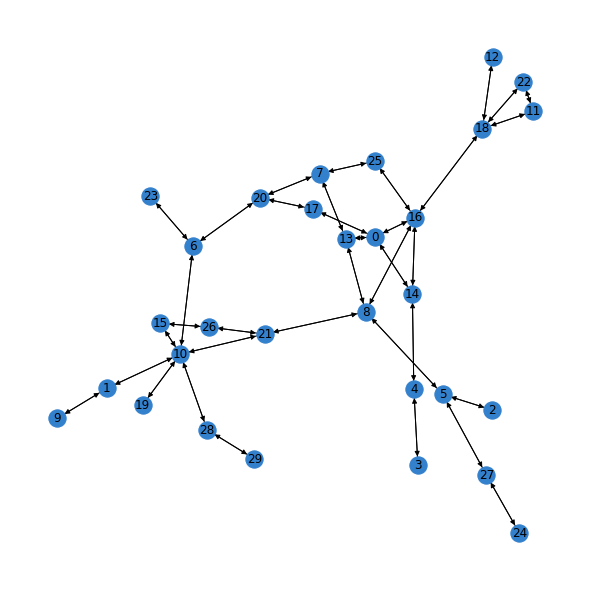

In [114]:
N = 30  # number of nodes
DAMP = 0.85  # damping factor
K = 10  # number of iterations
g = nx.nx.erdos_renyi_graph(N, 0.1)
g = dgl.DGLGraph(g)

plt.rcParams["figure.figsize"] = (8,8)
nx.draw(g.to_networkx(),  node_color=[[.2, .5, .8,]], with_labels=True)
plt.show()

### Assign to different data on the nodes

In [0]:
g.ndata['pv'] = torch.ones(N) / N
g.ndata['deg'] = g.out_degrees(g.nodes()).float()

In [116]:
g

DGLGraph(num_nodes=30, num_edges=72,
         ndata_schemes={'pv': Scheme(shape=(), dtype=torch.float32), 'deg': Scheme(shape=(), dtype=torch.float32)}
         edata_schemes={})

In [117]:
g.nodes()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [118]:
g.out_degrees(3), g.in_degrees(3), g.out_degrees(7)

(tensor([1]), tensor([1]), tensor([3]))

In [119]:
g.ndata['pv']

tensor([0.0333, 0.0333, 0.0333, 0.0333, 0.0333, 0.0333, 0.0333, 0.0333, 0.0333,
        0.0333, 0.0333, 0.0333, 0.0333, 0.0333, 0.0333, 0.0333, 0.0333, 0.0333,
        0.0333, 0.0333, 0.0333, 0.0333, 0.0333, 0.0333, 0.0333, 0.0333, 0.0333,
        0.0333, 0.0333, 0.0333])

In [120]:
g.ndata['deg']

tensor([4., 2., 1., 1., 2., 3., 3., 3., 4., 1., 6., 2., 1., 3., 3., 2., 5., 2.,
        4., 1., 3., 3., 2., 1., 1., 2., 2., 2., 2., 1.])

### Make four copies of the same graph for illustration purpose

In [0]:
g1, g2, g3, g4 = g.local_var(), g.local_var(), g.local_var(), g.local_var()

### Implementation of the page rank algorithm <br> $PV(u) = \frac{1-d}{N} + d ~\times~~ \sum_{v \in \mathcal{N}(u) } \frac{PV(v)}{D(v)} $ <br> The node aggregation function is invariant under permutation of the neighbouring nodes. <br> It's a two stage process, first the 'message' is passed by each node along all the edges, originating from the node. At the next step, all the 'messages' received by a node is used to update (in a permutation invariant way) to update the node data. 

In [0]:
def pagerank_message_func(edges):
    return {'pv' : edges.src['pv'] / edges.src['deg']}

In [0]:
def pagerank_reduce_func(nodes):
    msgs = torch.sum(nodes.mailbox['pv'], dim=1)
    pv = (1 - DAMP) / N + DAMP * msgs
    return {'pv' : pv}

### Notice the usage of 'mailbox', it stores all the data on a node, received through edges when the message function is executed. Each node has its individual 'mailbox'. Also notice, the contents of the mailbox are summed up and hence the final result doesn't depend on the order of the nodes which sent messages to a particular node

In [0]:
# -- register the message function & reduce function -- #
def register(g) : 
    g.register_message_func(pagerank_message_func)
    g.register_reduce_func(pagerank_reduce_func)

In [0]:
for g in [g1, g2, g3] : 
    register(g)

In [0]:
def pagerank_naive(g):
    # Phase #1: send out messages along all edges.
    for u, v in zip(*g.edges()):
        g.send((u, v))
    # Phase #2: receive messages to compute new PageRank values.
    for v in g.nodes():
        g.recv(v)

In [0]:
pagerank_naive(g1)

In [128]:
g1.ndata['pv'], g1.ndata['deg']

(tensor([0.0437, 0.0381, 0.0144, 0.0192, 0.0428, 0.0546, 0.0475, 0.0381, 0.0390,
         0.0192, 0.0947, 0.0263, 0.0121, 0.0286, 0.0319, 0.0239, 0.0499, 0.0215,
         0.0673, 0.0097, 0.0381, 0.0310, 0.0263, 0.0144, 0.0192, 0.0201, 0.0286,
         0.0428, 0.0381, 0.0192]),
 tensor([4., 2., 1., 1., 2., 3., 3., 3., 4., 1., 6., 2., 1., 3., 3., 2., 5., 2.,
         4., 1., 3., 3., 2., 1., 1., 2., 2., 2., 2., 1.]))

In [0]:
# for large graph use 
def pagerank_batch(g):
    g.send(g.edges())
    g.recv(g.nodes())

In [130]:
pagerank_batch(g2)
g2.ndata['pv'], g2.ndata['deg']

(tensor([0.0437, 0.0381, 0.0144, 0.0192, 0.0428, 0.0546, 0.0475, 0.0381, 0.0390,
         0.0192, 0.0947, 0.0263, 0.0121, 0.0286, 0.0319, 0.0239, 0.0499, 0.0215,
         0.0673, 0.0097, 0.0381, 0.0310, 0.0263, 0.0144, 0.0192, 0.0201, 0.0286,
         0.0428, 0.0381, 0.0192]),
 tensor([4., 2., 1., 1., 2., 3., 3., 3., 4., 1., 6., 2., 1., 3., 3., 2., 5., 2.,
         4., 1., 3., 3., 2., 1., 1., 2., 2., 2., 2., 1.]))

In [0]:
def pagerank_level2(g):
    g.update_all()

In [132]:
pagerank_level2(g3)
g3.ndata['pv'], g3.ndata['deg']

(tensor([0.0437, 0.0381, 0.0144, 0.0192, 0.0428, 0.0546, 0.0475, 0.0381, 0.0390,
         0.0192, 0.0947, 0.0263, 0.0121, 0.0286, 0.0319, 0.0239, 0.0499, 0.0215,
         0.0673, 0.0097, 0.0381, 0.0310, 0.0263, 0.0144, 0.0192, 0.0201, 0.0286,
         0.0428, 0.0381, 0.0192]),
 tensor([4., 2., 1., 1., 2., 3., 3., 3., 4., 1., 6., 2., 1., 3., 3., 2., 5., 2.,
         4., 1., 3., 3., 2., 1., 1., 2., 2., 2., 2., 1.]))

In [0]:
import dgl.function as fn
def pagerank_builtin(g):
    g.ndata['pv'] = g.ndata['pv'] / g.ndata['deg']
    g.update_all(message_func=fn.copy_src(src='pv', out='m'),
                 reduce_func=fn.sum(msg='m',out='m_sum'))
    g.ndata['pv'] = (1 - DAMP) / N + DAMP * g.ndata['m_sum']

In [139]:
pagerank_builtin(g4)
g4.ndata['pv'], g4.ndata['deg']

(tensor([0.0398, 0.0347, 0.0205, 0.0232, 0.0303, 0.0437, 0.0415, 0.0324, 0.0458,
         0.0212, 0.0780, 0.0305, 0.0193, 0.0334, 0.0409, 0.0306, 0.0545, 0.0251,
         0.0461, 0.0184, 0.0384, 0.0389, 0.0305, 0.0185, 0.0232, 0.0243, 0.0239,
         0.0368, 0.0347, 0.0212]),
 tensor([4., 2., 1., 1., 2., 3., 3., 3., 4., 1., 6., 2., 1., 3., 3., 2., 5., 2.,
         4., 1., 3., 3., 2., 1., 1., 2., 2., 2., 2., 1.]))

In [111]:
adj = g.adjacency_matrix()

/usr/local/lib/python3.6/dist-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


In [112]:
adj

tensor(indices=tensor([[ 4, 25, 28,  7, 13, 26, 28, 29,  8, 10, 11, 26, 27,  6,
                        17,  0,  8, 21, 23, 25, 28, 15, 19, 29,  3, 10,  1,  9,
                        19,  2,  4, 12,  7, 10, 14, 17,  2,  6,  9, 14, 16, 17,
                        24, 28,  2, 12, 13,  8, 11, 14, 19,  1, 11,  9, 10, 12,
                        15, 17, 21,  5, 14, 22, 25, 28, 10, 17, 19,  3,  9, 10,
                        14, 16, 27,  5,  7, 12, 16, 24, 22, 27,  4, 14, 22, 28,
                        15, 20, 21, 24,  4, 10, 19, 22, 26, 27,  0,  4, 15, 29,
                         1,  2, 24, 27,  2, 18, 20, 24, 26,  0,  1,  4, 10, 15,
                        21,  1,  5, 25],
                       [ 0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,
                         3,  4,  4,  4,  4,  4,  4,  5,  5,  5,  6,  6,  7,  7,
                         7,  8,  8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10,
                        10, 10, 11, 11, 11, 12, 12, 12, 12, 13, 13, 14, 14, 14,

In [140]:
dgl.base.DGLError

dgl._ffi.base.DGLError

In [146]:
torch.nn.Parameter(torch.Tensor(5, 3))

Parameter containing:
tensor([[2.7192e-36, 0.0000e+00, 2.1019e-44],
        [0.0000e+00, 1.4013e-45, 0.0000e+00],
        [2.3694e-38, 1.1340e+30, 7.1547e+22],
        [4.5828e+30, 1.2121e+04, 7.1846e+22],
        [9.2198e-39, 0.0000e+00, 4.6919e-32]], requires_grad=True)

In [142]:
g.in_degrees().view(-1, 1).shape

torch.Size([30, 1])

In [0]:
dgl.knn_graph??